# Ensemble classification model in earthquake building damage level detection

# Importing Libraries

In [ ]:
!pip install xgboost
!pip install catboost
!pip install imbalanced-ensemble

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 151 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 268 kB 11.4 MB/s 
     |████████████████████████████████| 11.2 MB 51.0 MB/s 
     |████████████████████████████████| 959 kB 53.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
import numpy as np
import pandas as pd
import cv2

from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from google.colab import drive

import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb

# Data Loading

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/train_values.csv", index_col='building_id')

In [ ]:
X.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
Y= pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/train_labels.csv", index_col='building_id')

In [ ]:
Y.head()

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3


In [ ]:
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/test_values.csv", index_col='building_id')

In [ ]:
X.describe()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
count,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,...,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,0.034332,...,0.064378,0.033626,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119
std,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,0.182081,...,0.245426,0.180265,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Feature Engineering : Conditional Probabilities of geo_levels

#### ID-1

In [ ]:
fea = pd.merge(X, Y, on='building_id')

In [ ]:
#this block of code calculates the probabilities
damage1 = {}
damage2 = {}
damage3 = {}

for i,j in (X['geo_level_1_id'].value_counts()).iteritems():
    
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_1_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_1_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_1_id']==i])

    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# this block of code appends a new column/feature of probabilities
list1 = []
list2 = []
list3 = []

for i in X['geo_level_1_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

X['prob1_geo1'] = list1
X['prob2_geo1'] = list2
X['prob3_geo1'] = list3

In [ ]:
list1 = []
list2 = []
list3 = []

for i in test['geo_level_1_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

test['prob1_geo1'] = list1
test['prob2_geo1'] = list2
test['prob3_geo1'] = list3

#### ID-2

In [ ]:
damage1 = {}
damage2 = {}
damage3 = {}

for i,j in ((X['geo_level_2_id'].value_counts()).iteritems()):
    
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_2_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_2_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_2_id']==i])

    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [ ]:
list1 = []
list2 = []
list3 = []

for i in X['geo_level_2_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

X['prob1_geo2'] = list1
X['prob2_geo2'] = list2
X['prob3_geo2'] = list3

In [ ]:
list1 = []
list2 = []
list3 = []

for i in test['geo_level_2_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

test['prob1_geo2'] = list1
test['prob2_geo2'] = list2
test['prob3_geo2'] = list3

#### ID-3

In [ ]:
damage1 = {}
damage2 = {}
damage3 = {}

for i,j in ((X['geo_level_3_id'].value_counts()).iteritems()):
    
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_3_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_3_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_3_id']==i])

    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [ ]:
list1 = []
list2 = []
list3 = []

for i in X['geo_level_3_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

X['prob1_geo3'] = list1
X['prob2_geo3'] = list2
X['prob3_geo3'] = list3

In [ ]:
list1 = []
list2 = []
list3 = []

for i in test['geo_level_3_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

test['prob1_geo3'] = list1
test['prob2_geo3'] = list2
test['prob3_geo3'] = list3

# Feature Engineering: Finding relation between geo_levels using seq_to_seq method (LSTM)

<font size=2> **Below is just an example to show how the geo_levels might be related in some way to each other.**
**For geo_level_1 = 6 and geo_level_2=487 we see there are a lot of same geo_levels-3 indicating that there is some relation between these levels.**</font>

In [ ]:
pd.DataFrame(X['geo_level_3_id'][X['geo_level_2_id']==487][X['geo_level_1_id']==6]).head(50)

,geo_level_3_id
building_id,
802906,12198
959468,12198
410679,7439
423950,7439
215003,12198
594969,835
695349,2908
869506,7439
141511,382


### Converting the geo_levels 1 and 2 into one hot encoder with shared vocabulary

In [ ]:
l1 = pd.concat([X['geo_level_1_id'], test['geo_level_1_id']])
l2 = pd.concat([X['geo_level_2_id'], test['geo_level_2_id']])
l3 = pd.concat([X['geo_level_3_id'], test['geo_level_3_id']])

In [ ]:
#get shared vocab of l1 and l2
inp = pd.concat([l1,l2]).to_numpy().reshape(-1,1)

In [ ]:
l1 = pd.concat([X['geo_level_1_id'], test['geo_level_1_id']]).to_numpy().reshape(-1,1)

In [ ]:
l2 = pd.concat([X['geo_level_2_id'], test['geo_level_2_id']]).to_numpy().reshape(-1,1)

In [ ]:
onehot = OneHotEncoder(sparse=False)

In [ ]:
onehot.fit(inp)

OneHotEncoder(sparse=False)

In [ ]:
inp.shape

(694938, 1)

In [ ]:
onehot.categories_

[array([   0,    1,    2, ..., 1425, 1426, 1427])]

In [ ]:
l1_hot = onehot.transform(l1)

In [ ]:
l1_hot.shape

(347469, 1419)

In [ ]:
l2_hot = onehot.transform(l2)

In [ ]:
l2_hot.shape

(347469, 1419)

In [ ]:
fin_inp = np.stack((l1_hot,l2_hot), axis=1)
fin_inp.shape

(347469, 2, 1419)

### Converting geo_level_3 into onehot

In [ ]:
l3_hot = np.array(pd.get_dummies(l3))

In [ ]:
l3_hot.shape

(347469, 11861)

### Creating a LSTM model to get relation features.

In [ ]:
inpx = Input( shape=fin_inp.shape[1:] )  

lstm = LSTM(16, )(inpx)

lvl3 = Dense(l3_hot.shape[1], activation='sigmoid')(lstm)

modelf = Model(inputs= inpx, outputs=lvl3)

modelf.compile(loss='binary_crossentropy', optimizer='adam')

modelf.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 1419)]         0         
                                                                 
 lstm (LSTM)                 (None, 16)                91904     
                                                                 
 dense (Dense)               (None, 11861)             201637    
                                                                 
Total params: 293,541
Trainable params: 293,541
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelf.fit(fin_inp, l3_hot, epochs=30, batch_size=128)

Epoch 1/30
2715/2715 [==============================] - 23s 6ms/step - loss: 0.0399
Epoch 2/30
2715/2715 [==============================] - 15s 6ms/step - loss: 9.6936e-04
Epoch 3/30
2715/2715 [==============================] - 15s 6ms/step - loss: 8.4829e-04
Epoch 4/30
2715/2715 [==============================] - 15s 6ms/step - loss: 8.3362e-04
Epoch 5/30
2715/2715 [==============================] - 15s 6ms/step - loss: 8.3092e-04
Epoch 6/30
2715/2715 [==============================] - 15s 6ms/step - loss: 8.3016e-04
Epoch 7/30
2715/2715 [==============================] - 15s 6ms/step - loss: 8.2985e-04
Epoch 8/30
2715/2715 [==============================] - 15s 5ms/step - loss: 8.2971e-04
Epoch 9/30
2715/2715 [==============================] - 15s 6ms/step - loss: 8.2964e-04
Epoch 10/30
2715/2715 [==============================] - 15s 6ms/step - loss: 8.2957e-04
Epoch 11/30
2715/2715 [==============================] - 15s 6ms/step - loss: 8.2952e-04
Epoch 12/30
2715/2715 [===========

### Getting the relation vector from the output of intermediate layer

In [ ]:
inter = Model(inputs=modelf.input, outputs=modelf.layers[1].output)

<font size=3>**Train**</font>

In [ ]:
l1 = X['geo_level_1_id'].to_numpy().reshape(-1,1)

l2 = X['geo_level_2_id'].to_numpy().reshape(-1,1)

In [ ]:
l1_hot = onehot.transform(l1)
l2_hot = onehot.transform(l2)


In [ ]:
fin_inp = np.stack((l1_hot,l2_hot), axis=1)
fin_inp.shape

(260601, 2, 1419)

In [ ]:
geo_fea_train = inter.predict(fin_inp)

<font size=3>**Test**</font>

In [ ]:
l1 = test['geo_level_1_id'].to_numpy().reshape(-1,1)

l2 = test['geo_level_2_id'].to_numpy().reshape(-1,1)

In [ ]:
l1_hot = onehot.transform(l1)
l2_hot = onehot.transform(l2)


In [ ]:
fin_inp = np.stack((l1_hot,l2_hot), axis=1)
fin_inp.shape

(86868, 2, 1419)

In [ ]:
geo_fea_test = inter.predict(fin_inp)

# Final  Data

In [ ]:
print("train {}, test {}  ".format(geo_fea_train.shape, geo_fea_test.shape))

train (260601, 16), test (86868, 16)  


### Preprocessing the data with pd.get_dummies and adding the relation features

In [ ]:
fx_tr = np.hstack((np.array(pd.get_dummies(X.copy().drop(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'], axis=1))),
                   geo_fea_train))

In [ ]:
fx_tr

array([[ 2.        , 30.        ,  6.        , ..., -0.96217817,
        -0.96350002, -0.96347404],
       [ 2.        , 10.        ,  8.        , ...,  0.96365118,
        -0.96337324, -0.96339047],
       [ 2.        , 10.        ,  5.        , ...,  0.96315789,
        -0.9629187 , -0.96263766],
       ...,
       [ 3.        , 55.        ,  6.        , ...,  0.96352947,
        -0.96339977, -0.96340472],
       [ 2.        , 10.        , 14.        , ...,  0.96371937,
        -0.96360976, -0.96362954],
       [ 3.        , 10.        ,  7.        , ...,  0.96316606,
        -0.96292514, -0.96264213]])

In [ ]:
fx_tr.shape

(260601, 90)

In [ ]:
test.fillna(value=0, inplace=True)

In [ ]:
fx_te = np.hstack((np.array(pd.get_dummies(test.copy().drop(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'], axis=1))), geo_fea_test))

fx_te.shape

(86868, 90)

In [ ]:
fy_tr = Y.to_numpy().ravel()
fy_tr.shape

(260601,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(fx_tr, fy_tr, test_size=0.2, random_state=42)

# Research hyperparameters

In [ ]:
!pip install hpbandster
!pip install hpbandster-sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 115 kB/s 
     |████████████████████████████████| 89 kB 8.7 MB/s 
     |████████████████████████████████| 4.9 MB 69.4 MB/s 
  Created wheel for hpbandster: filename=hpbandster-0.7.4-py3-none-any.whl size=80006 sha256=cbc5a34760670cf0c81cd2e12e33c25d63fd57c9cf7200ccd2f90f65c6590b13
  Stored in directory: /root/.cache/pip/wheels/d9/88/fc/61ab6b9f386a386839668631c39a6dc3c2fb0ec7000d552faa
Successfully built hpbandster
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH
from sklearn import tree
from sklearn.utils.validation import check_is_fitted
from hpbandster_sklearn import HpBandSterSearchCV

In [ ]:
#input best params here from randm.best_params_
modelrandonforest = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

search_space = CS.ConfigurationSpace(seed=42)
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("n_estimators", 200, 500))
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("max_depth", 2, 15))
search_space.add_hyperparameter(CSH.CategoricalHyperparameter("max_features", ["auto", "sqrt","log2"]))
search_space.add_hyperparameter(CSH.CategoricalHyperparameter("criterion", ["gini", "entropy"]))

search = HpBandSterSearchCV(modelrandonforest, search_space, random_state=42, n_jobs=1, n_iter=10, verbose=0, optimizer = 'hyperband').fit(X_train,y_train)

search.best_params_

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 14, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 12, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 14, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 14, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_sample

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 11, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_sa

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 14, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 13, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 13, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 12, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 13, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 12, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 12, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
[{'fit_error': None, 'test_scores': {'score': 0.7078136991557943}, 'n_test_samples': 41696, 'fit_time': 1.3266842365264893, 'score_time': 0.054590463638305664}, {'fit_error': None, 'test_scores': {'score': 0.7119627782041443}, 'n_test_samples': 41696, 'fit_time': 1.3187243938446045, 'score_time': 0.049369096755981445}, {'fit_error': None, 'test_scores': {'score': 0.7063507290867229}, 'n_test_samples': 41696, 'fit_time': 1.2675046920776367, 'score_time': 0.04341697692871094}, {'fit_error': None, 'test_scores': {'score': 0.7101640445126631}, 'n_test_samples': 41696, 'fit_time': 1.2885687351226807, 'score_ti

Exception in thread discover_workers:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/Pyro4/core.py", line 515, in connect_and_handshake
    sslContext=sslContext)
  File "/usr/local/lib/python3.7/dist-packages/Pyro4/socketutil.py", line 307, in createSocket
    sock.connect(connect)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/Pyro4/core.py", line 2009, in _locateNS
    proxy._pyroBind()
  File "/usr/local/lib/python3.7/dist-packages/Pyro4/core.py", line 408, in _pyroBind
    return self.__pyroCreateConnection(True)
  File "/usr/local/lib/python3.7/dist-packages/Pyro4/core.py", line 596, in __pyroCreateConnection
    connect_and_handshake(conn)
  File "/usr/local/lib/python3.7/dist-packages/Pyro4/core.py", line 549, in connect_and_handshake
    raise ce
Pyro4.errors.CommunicationError: canno

{'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt'}

In [ ]:
#input best params here from randm.best_params_
modelrandonforest = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

search_space = CS.ConfigurationSpace(seed=42)
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("n_estimators", 200, 500))
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("max_depth", 2, 15))
search_space.add_hyperparameter(CSH.CategoricalHyperparameter("max_features", ["auto", "sqrt","log2"]))
search_space.add_hyperparameter(CSH.CategoricalHyperparameter("criterion", ["gini", "entropy"]))

search = HpBandSterSearchCV(modelrandonforest, search_space, random_state=42, n_jobs=1, n_iter=10, verbose=0, optimizer = 'bohb').fit(X_train,y_train)

search.best_params_

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 13, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 13, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 14, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divi

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 13, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 11, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 12, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 11, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 13, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)
[[0.         0.96428638 0.        ]
 [1.         0.8928577  0.        ]
 [0.         0.96428638 1.        ]
 [0.         0.46428566 1.        ]]
[[0.         0.82142903 2.        ]
 [0.         0.60714301 2.        ]
 [1.         0.60714301 2.        ]
 [0.         0.67857168 2.        ]
 [0.         0.82142903 2.        ]]
[0.37652857 0.18108369 0.43477774]
[0.3369093  0.08160833 0.001     ]


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divi

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divi

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divi

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 13, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 13, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divi

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divi

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divi

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 13, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 11, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divi

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 13, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divi

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 13, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 13, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
[{'fit_error': None, 'test_scores': {'score': 0.7436444742900997}, 'n_test_samples': 41696, 'fit_time': 1.90576171875, 'score_time': 0.0615234375}, {'fit_error': None, 'test_scores': {'score': 0.7449395625479662}, 'n_test_samples': 41696, 'fit_time': 1.8657312393188477, 'score_time': 0.061919212341308594}, {'fit_error': None, 'test_scores': {'score': 0.7438603223330775}, 'n_test_samples': 41696, 'fit_time': 1.7940187454223633, 'score_time': 0.057642459869384766}, {'fit_error': None, 'test_scores': {'score': 0.7490646584804298}, 'n_test_samples': 41696, 'fit_time': 1.8370840549468994, 'score_time': 0.058030

{'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto'}

In [ ]:
#input best params here from randm.best_params_
modellgb = lgb.LGBMClassifier(random_seed=42, silent=True)

parameters = {
    'n_estimators': [100],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'num_leaves': [50, 100, 200],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [20]
}

search_space = CS.ConfigurationSpace(seed=42)
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("n_estimators", 200, 500))
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("max_depth", 2, 25))
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("num_leaves", 20, 200))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("colsample_bytree", 0.5, 0.8))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("reg_alpha", 1.1, 1.5))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("reg_lambda", 1.1, 1.5))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("min_split_gain", 0.3, 0.6))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("subsample", 0.5, 0.9))

search = HpBandSterSearchCV(modellgb, search_space, random_state=42, n_jobs=1, n_iter=10, verbose=0, optimizer = 'hyperband').fit(X_train,y_train)

search.best_params_

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.7612045386129362, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 15, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.306294825421156, 'n_estimators': 11, 'n_jobs': 1, 'num_leaves': 97, 'objective': None, 'random_state': None, 'reg_alpha': 1.2276557231804375, 'reg_lambda': 1.3670582700971294, 'silent': True, 'subsample': 0.7368290247542911, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'random_seed': 42, 'warm_start': True}
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.6045142424689594, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 17, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.5138446316790785, 'n_estimators': 11, 'n_jobs': 1, 'num_leaves': 189, 'objective': None, 'random_state': None, 'reg_alpha': 1.237902986855245, 'reg_lambda': 1.3527955744771791, 'silent': True, 'subsample': 0.67819881518705, 'subsamp

{'colsample_bytree': 0.5929536819424027,
 'max_depth': 23,
 'min_split_gain': 0.44237377666027666,
 'num_leaves': 176,
 'reg_alpha': 1.183419847375915,
 'reg_lambda': 1.3645598499353226,
 'subsample': 0.6495201619857017}

In [ ]:
#input best params here from randm.best_params_
modellgb = lgb.LGBMClassifier(random_seed=42, silent=True)

parameters = {
    'n_estimators': [100],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'num_leaves': [50, 100, 200],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [20]
}

search_space = CS.ConfigurationSpace(seed=42)
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("n_estimators", 200, 500))
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("max_depth", 2, 25))
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("num_leaves", 20, 200))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("colsample_bytree", 0.5, 0.8))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("reg_alpha", 1.1, 1.5))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("reg_lambda", 1.1, 1.5))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("min_split_gain", 0.3, 0.6))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("subsample", 0.5, 0.9))

search = HpBandSterSearchCV(modellgb, search_space, random_state=42, n_jobs=1, n_iter=10, verbose=0, optimizer = 'bohb').fit(X_train,y_train)

search.best_params_

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.7372682318746131, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.5909131027361108, 'n_estimators': 11, 'n_jobs': 1, 'num_leaves': 83, 'objective': None, 'random_state': None, 'reg_alpha': 1.3484405966072497, 'reg_lambda': 1.4325273239139118, 'silent': True, 'subsample': 0.6565548031661685, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'random_seed': 42, 'warm_start': True}
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.5169112880677261, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 21, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.42110167072735144, 'n_estimators': 11, 'n_jobs': 1, 'num_leaves': 177, 'objective': None, 'random_state': None, 'reg_alpha': 1.1284677373354415, 'reg_lambda': 1.4963947058857046, 'silent': True, 'subsample': 0.8211727233311314, 'sub

{'colsample_bytree': 0.6827796405988583,
 'max_depth': 20,
 'min_split_gain': 0.4587016916738572,
 'num_leaves': 145,
 'reg_alpha': 1.135108783125248,
 'reg_lambda': 1.1654451815731937,
 'subsample': 0.7840896234260089}

In [ ]:
#input best params here from randm.best_params_
modelextratrees = ExtraTreesClassifier(random_state=42)

param_grid = {  
    "n_estimators": [360,500],
    "max_depth": [4,5,6,7,8,25,30,32] 
}

search_space = CS.ConfigurationSpace(seed=42)
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("n_estimators", 200, 500))
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("max_depth", 2, 50))

search = HpBandSterSearchCV(modelextratrees, search_space, random_state=42, n_jobs=1, n_iter=10, verbose=0, optimizer = 'hyperband').fit(X_train,y_train)

search.best_params_

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 27, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 29, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 49, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 43, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 40, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 38, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 21, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 27, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 29, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 27, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 24, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 44, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_sam

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 29, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 24, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 39, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 49, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 36, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 50, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 39, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 38, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 42, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 23, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 17, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 50, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 39, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 38, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 50, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 48, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 28, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_sam

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 37, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 48, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 47, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 18, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 29, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 23, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 18, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 44, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 28, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 37, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 19, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 29, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 18, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 48, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 23, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 18, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 44, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 23, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_sampl

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 33, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 31, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 22, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 43, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 13, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 33, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 22, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 22, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 22, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
[{'fit_error': None, 'test_scores': {'score': 0.7393514965464313}, 'n_test_samples': 41696, 'fit_time': 5.111952781677246, 'score_time': 0.2038271427154541}, {'fit_error': None, 'test_scores': {'score': 0.7356580966999232}, 'n_test_samples': 41696, 'fit_time': 4.991957187652588, 'score_time': 0.20180249214172363}, {'fit_error': None, 'test_scores': {'score': 0.7376966615502686}, 'n_test_samples': 41696, 'fit_time': 4.968655347824097, 'score_time': 0.20122146606445312}, {'fit_error': None, 'test_scores': {'score': 0.7381523407521106}, 'n_test_samples': 41696, 'fit_time': 5.082496166229248, 'score_time': 0.20

{'max_depth': 14}

In [ ]:
#input best params here from randm.best_params_
modelextratrees = ExtraTreesClassifier(random_state=42)

param_grid = {  
    "n_estimators": [360,500],
    "max_depth": [4,5,6,7,8,25,30,32] 
}

search_space = CS.ConfigurationSpace(seed=42)
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("n_estimators", 200, 500))
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("max_depth", 2, 50))

search = HpBandSterSearchCV(modelextratrees, search_space, random_state=42, n_jobs=1, n_iter=10, verbose=0, optimizer = 'bohb').fit(X_train,y_train)

search.best_params_

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 23, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 49, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 29, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 23, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_sampl

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 32, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 29, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 33, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 38, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 32, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 29, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 27, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 29, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 29, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 33, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 28, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 43, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samp

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 42, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 28, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 21, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 14, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samp

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 22, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:430: UserWarning: Warm-start fitt

{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': True}
[{'fit_error': None, 'test_scores': {'score': 0.6763958173445894}, 'n_test_samples': 41696, 'fit_time': 0.7732999324798584, 'score_time': 0.04207134246826172}, {'fit_error': None, 'test_scores': {'score': 0.6764198004604758}, 'n_test_samples': 41696, 'fit_time': 0.7748472690582275, 'score_time': 0.041429758071899414}, {'fit_error': None, 'test_scores': {'score': 0.6751007290867229}, 'n_test_samples': 41696, 'fit_time': 0.7755236625671387, 'score_time': 0.0423436164855957}, {'fit_error': None, 'test_scores': {'score': 0.6771392939370683}, 'n_test_samples': 41696, 'fit_time': 0.784003734588623, 'score_time': 

In [ ]:
modelgradient = GradientBoostingClassifier(random_state=42)

param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.15, 0.2],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.618,0.85],
    "n_estimators":[200,400]
    }

search_space = CS.ConfigurationSpace(seed=42)
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("n_estimators", 200, 500))
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("max_depth", 3, 20))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("learning_rate", 0.01, 0.3))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("subsample", 0.5, 0.9))
search_space.add_hyperparameter(CSH.CategoricalHyperparameter("max_features", ["log2", "sqrt"]))

search = HpBandSterSearchCV(modelgradient, search_space, random_state=42, n_jobs=1, n_iter=10, verbose=0, optimizer = 'hyperband').fit(X_train,y_train)

search.best_params_

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.19144501529165314, 'loss': 'deviance', 'max_depth': 4, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.806252535193474, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': True}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.2603354694838294, 'loss': 'deviance', 'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.7242142938863336, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': True}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 

{'learning_rate': 0.1282924876381138,
 'max_depth': 6,
 'max_features': 'sqrt',
 'subsample': 0.5637360446391372}

In [ ]:
modelgradient = GradientBoostingClassifier(random_state=42)

param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.15, 0.2],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.618,0.85],
    "n_estimators":[200,400]
    }

search_space = CS.ConfigurationSpace(seed=42)
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("n_estimators", 200, 500))
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("max_depth", 3, 20))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("learning_rate", 0.01, 0.3))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("subsample", 0.5, 0.9))
search_space.add_hyperparameter(CSH.CategoricalHyperparameter("max_features", ["log2", "sqrt"]))

search = HpBandSterSearchCV(modelgradient, search_space, random_state=42, n_jobs=1, n_iter=10, verbose=0, optimizer = 'bohb').fit(X_train,y_train)

search.best_params_

{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.12427650395776389, 'loss': 'deviance', 'max_depth': 13, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.5572341154040767, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': True}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.2655931859549792, 'loss': 'deviance', 'max_depth': 9, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.5056779433569254, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': True}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None

/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.29584479628096777, 'loss': 'deviance', 'max_depth': 12, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 33, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.7662101996842661, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': True}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.0844976818550991, 'loss': 'deviance', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.8865132209531692, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.07841323051233709, 'loss': 'deviance', 'max_depth': 12, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.7563798615382117, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': True}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.22266885265827313, 'loss': 'deviance', 'max_depth': 12, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.8353738386109477, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': True}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.27252654401702525, 'loss': 'deviance', 'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.5175604278474615, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': True}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.16718114423008484, 'loss': 'deviance', 'max_depth': 17, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 11, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.6222756353048516, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': True}
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': No

{'learning_rate': 0.2584369314981252,
 'max_depth': 7,
 'max_features': 'sqrt',
 'subsample': 0.5009971073008392}

In [ ]:
modelada = AdaBoostClassifier(random_state=42)

param_grid = {
    "algorithm":["SAMME","SAMME.R"],
    "learning_rate": [0.01, 0.025, 0.15, 0.2],
    "n_estimators":[200,400, 500, 1000]
    }

search_space = CS.ConfigurationSpace(seed=42)
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("n_estimators", 200, 1000))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("learning_rate", 0.01, 0.3))
search_space.add_hyperparameter(CSH.CategoricalHyperparameter("algorithm", ["SAMME", "SAMME.R"]))

search = HpBandSterSearchCV(modelada, search_space, random_state=42, n_jobs=1, n_iter=10, verbose=0, optimizer = 'hyperband').fit(X_train,y_train)

search.best_params_

{'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.1558078678552362, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.2915404068118255, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.04127696534742428, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.24170364877067152, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.25663462032283, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.28664631112459077, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.2857892616484671, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.27238243045816013, 'n_estimators': 11, 'random_state': 42}


{'algorithm': 'SAMME.R', 'learning_rate': 0.2915404068118255}

In [ ]:
modelada = AdaBoostClassifier(random_state=42)

param_grid = {
    "algorithm":["SAMME","SAMME.R"],
    "learning_rate": [0.01, 0.025, 0.15, 0.2],
    "n_estimators":[200,400, 500, 1000]
    }

search_space = CS.ConfigurationSpace(seed=42)
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("n_estimators", 200, 1000))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("learning_rate", 0.01, 0.3))
search_space.add_hyperparameter(CSH.CategoricalHyperparameter("algorithm", ["SAMME", "SAMME.R"]))

search = HpBandSterSearchCV(modelada, search_space, random_state=42, n_jobs=1, n_iter=10, verbose=0, optimizer = 'bohb').fit(X_train,y_train)

search.best_params_

{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.1954704038806794, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.12189874254774426, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.03355455108241048, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.12289295382273062, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.19364312187281255, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.1169354723238261, 'n_estimators': 11, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)
[[1.         0.38585773]
 [1.         0.38928605]
 [0.         0.36874301]]
[[1.         0.08122259]
 [1.         0.63955312]
 [1.         0.63325214]]
[0.41608245 0.00793117]
[0.001      0.23101183]


{'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.11397052448491053, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.18249641045679316, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.12204699283176923, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.12189874254774426, 'n_estimators': 33, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.12289295382273062, 'n_estimators': 33, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.12204699283176923, 'n_estimators': 33, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.12289295382273062, 'n_estimators': 100, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.12205722779027543, 'n_estimators': 33, 'random_state': 42}
{'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.13885173832341552, 'n_estimators': 33, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.060078043878380366, 'n_estimators': 33, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.12205722779027543, 'n_estimators': 100, 'random_state': 42}
{'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.05166148122145417, 'n_estimators': 100, 'random_state': 42}
{'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.17154191379260905, 'n_estimators': 100, 'random_state': 42}
{'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.2555762052900447, 'n_estimators': 100, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.12217764261392278, 'n_estimators': 11, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.12210120499128978, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.2987943332726197, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.05416081030357051, 'n_estimators': 11, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.12206300301188805, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.0685940345294758, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.09397402391037203, 'n_estimators': 11, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.12212762505259674, 'n_estimators': 11, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.12207622564239064, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.12217764261392278, 'n_estimators': 33, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.12210120499128978, 'n_estimators': 33, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.2987943332726197, 'n_estimators': 33, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.2987943332726197, 'n_estimators': 100, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.156498229430262, 'n_estimators': 33, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)
[[1.         0.99584253]
 [1.         0.38928605]
 [1.         0.38640423]]
[[0.         0.8468145 ]
 [0.         0.55704108]
 [0.         0.14366028]]
[0.001      0.25297917]
[0.001      0.25467478]


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.26783471726748037, 'n_estimators': 33, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)
[[1.         0.99584253]
 [1.         0.38928605]
 [1.         0.38640423]]
[[0.         0.8468145 ]
 [0.         0.55704108]
 [0.         0.14366028]]
[0.001      0.25297917]
[0.001      0.25467478]


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.294115720358911, 'n_estimators': 33, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.294115720358911, 'n_estimators': 100, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.29317217788971, 'n_estimators': 100, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.293958072542143, 'n_estimators': 100, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.2941463466630024, 'n_estimators': 100, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.29426106993968043, 'n_estimators': 11, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.29419783815199607, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.20341490202646229, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.19141092809137686, 'n_estimators': 11, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.2943355073236853, 'n_estimators': 11, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.2942780098369813, 'n_estimators': 11, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.29417935951340846, 'n_estimators': 11, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.29435420326565664, 'n_estimators': 11, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.29430667751008993, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.2943355073236853, 'n_estimators': 33, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.29435420326565664, 'n_estimators': 33, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.29430667751008993, 'n_estimators': 33, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.29430667751008993, 'n_estimators': 100, 'random_state': 42}
{'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.25393498653312047, 'n_estimators': 33, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.2941586013023392, 'n_estimators': 33, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.29433354214581087, 'n_estimators': 33, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.29433354214581087, 'n_estimators': 100, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.2942597613104917, 'n_estimators': 100, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.29417022567868367, 'n_estimators': 100, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.2943043909351701, 'n_estimators': 100, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.2942701958060098, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.08804570669294493, 'n_estimators': 11, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.29432882940304145, 'n_estimators': 11, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.2943275802569906, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.0946866323580264, 'n_estimators': 11, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.2944549772860072, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME', 'base_estimator': None, 'learning_rate': 0.03605314567588389, 'n_estimators': 11, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.2943143337533701, 'n_estimators': 11, 'random_state': 42}


/usr/local/lib/python3.7/dist-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.29415989964135275, 'n_estimators': 11, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.29432882940304145, 'n_estimators': 33, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.2943275802569906, 'n_estimators': 33, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.2944549772860072, 'n_estimators': 33, 'random_state': 42}
{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.29432882940304145, 'n_estimators': 100, 'random_state': 42}
[{'fit_error': None, 'test_scores': {'score': 0.712178626247122}, 'n_test_samples': 41696, 'fit_time': 5.122389793395996, 'score_time': 0.15196847915649414}, {'fit_error': None, 'test_scores': {'score': 0.7096603990790483}, 'n_test_samples': 41696, 'fit_time': 5.141468048095703, 'score_time': 0.1529693603515625}, {'fit_error': None, 'test_scores': {'score': 0.7097

{'algorithm': 'SAMME.R', 'learning_rate': 0.2941463466630024}

In [ ]:
modelcat = CatBoostClassifier(random_state=42)

search_space = CS.ConfigurationSpace(seed=42)
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("border_count", 5, 30))
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("depth", 5, 30))
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("l2_leaf_reg", 5, 30))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("learning_rate", 0.01, 0.3))

modelcat_hyperband = HpBandSterSearchCV(modelcat, search_space, random_state=42, n_jobs=1, n_iter=10, verbose=0, optimizer = 'hyperband').fit(X_train,y_train)

modelcat_hyperband.best_params_

Streaming output truncated to the last 5000 lines.
76:	learn: 0.4649301	total: 10.5s	remaining: 3.14s
77:	learn: 0.4649198	total: 10.7s	remaining: 3.01s
78:	learn: 0.4649064	total: 10.8s	remaining: 2.88s
79:	learn: 0.4648896	total: 11s	remaining: 2.74s
80:	learn: 0.4648652	total: 11.1s	remaining: 2.6s
81:	learn: 0.4648486	total: 11.2s	remaining: 2.47s
82:	learn: 0.4648342	total: 11.4s	remaining: 2.33s
83:	learn: 0.4648236	total: 11.5s	remaining: 2.19s
84:	learn: 0.4648106	total: 11.6s	remaining: 2.05s
85:	learn: 0.4647940	total: 11.8s	remaining: 1.92s
86:	learn: 0.4647837	total: 11.9s	remaining: 1.78s
87:	learn: 0.4647660	total: 12.1s	remaining: 1.65s
88:	learn: 0.4647522	total: 12.2s	remaining: 1.51s
89:	learn: 0.4647354	total: 12.4s	remaining: 1.38s
90:	learn: 0.4647214	total: 12.5s	remaining: 1.24s
91:	learn: 0.4647077	total: 12.6s	remaining: 1.1s
92:	learn: 0.4646853	total: 12.8s	remaining: 963ms
93:	learn: 0.4646664	total: 12.9s	remaining: 826ms
94:	learn: 0.4646503	total: 13.1s	r

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [       nan 0.75590464 0.75885936        nan 0.75045088 0.75980909
        nan 0.75132387 0.76034632 0.76140157        nan 0.74518419
        nan 0.75566002 0.75982348        nan        nan 0.76230334
        nan 0.76081639 0.75293074 0.75751151        nan        nan
        nan 0.74433039 0.75831255        nan 0.75548734 0.76067728
 0.75904643        nan        nan 0.75644186        nan 0.75974194
 0.76192441 0.76237529        nan 0.76166059        nan 0.75599098
 0.75865311        nan 0.75246067        nan 0.75253741 0.75375576
 0.75955487 0.75589025 0.76007291 0.76076842        nan        nan
        nan        nan        nan 0.75865311 0.76129605 0.76256236
        nan 0.75652341 0.76075883        nan        nan 0.75367901
 0.75574156 0.75773695 0.76127206 0.75823101 0.76152149 0.7622218
        nan]
  category=UserWarning,


0:	learn: 0.8914184	total: 47.7ms	remaining: 4.72s
1:	learn: 0.7823943	total: 95.1ms	remaining: 4.66s
2:	learn: 0.7127819	total: 140ms	remaining: 4.52s
3:	learn: 0.6682537	total: 194ms	remaining: 4.65s
4:	learn: 0.6359459	total: 246ms	remaining: 4.68s
5:	learn: 0.6114521	total: 301ms	remaining: 4.71s
6:	learn: 0.5935387	total: 354ms	remaining: 4.7s
7:	learn: 0.5801775	total: 406ms	remaining: 4.66s
8:	learn: 0.5716063	total: 453ms	remaining: 4.58s
9:	learn: 0.5630058	total: 504ms	remaining: 4.54s
10:	learn: 0.5566678	total: 556ms	remaining: 4.5s
11:	learn: 0.5513598	total: 601ms	remaining: 4.41s
12:	learn: 0.5475354	total: 648ms	remaining: 4.34s
13:	learn: 0.5445127	total: 691ms	remaining: 4.25s
14:	learn: 0.5416440	total: 746ms	remaining: 4.22s
15:	learn: 0.5394538	total: 794ms	remaining: 4.17s
16:	learn: 0.5373301	total: 838ms	remaining: 4.09s
17:	learn: 0.5357258	total: 881ms	remaining: 4.01s
18:	learn: 0.5342197	total: 933ms	remaining: 3.98s
19:	learn: 0.5330310	total: 980ms	remaini

{'border_count': 13,
 'depth': 7,
 'l2_leaf_reg': 29,
 'learning_rate': 0.2644284124804845}

In [ ]:
modelcat = CatBoostClassifier(random_state=42)

search_space = CS.ConfigurationSpace(seed=42)
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("border_count", 5, 30))
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("depth", 5, 30))
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("l2_leaf_reg", 5, 30))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("learning_rate", 0.01, 0.3))

modelcat_bohb = HpBandSterSearchCV(modelcat, search_space, random_state=42, n_jobs=1, n_iter=10, verbose=0, optimizer = 'bohb').fit(X_train,y_train)

modelcat_bohb.best_params_

Streaming output truncated to the last 5000 lines.
79:	learn: 0.4340416	total: 36.6s	remaining: 9.14s
80:	learn: 0.4340185	total: 37s	remaining: 8.68s
81:	learn: 0.4339668	total: 37.5s	remaining: 8.22s
82:	learn: 0.4339157	total: 37.9s	remaining: 7.77s
83:	learn: 0.4338624	total: 38.4s	remaining: 7.31s
84:	learn: 0.4338227	total: 38.8s	remaining: 6.85s
85:	learn: 0.4337730	total: 39.3s	remaining: 6.39s
86:	learn: 0.4337311	total: 39.7s	remaining: 5.93s
87:	learn: 0.4337100	total: 40.2s	remaining: 5.48s
88:	learn: 0.4336783	total: 40.6s	remaining: 5.02s
89:	learn: 0.4336429	total: 41.1s	remaining: 4.56s
90:	learn: 0.4335914	total: 41.5s	remaining: 4.11s
91:	learn: 0.4335382	total: 42s	remaining: 3.65s
92:	learn: 0.4335208	total: 42.4s	remaining: 3.19s
93:	learn: 0.4335069	total: 42.9s	remaining: 2.74s
94:	learn: 0.4334753	total: 43.3s	remaining: 2.28s
95:	learn: 0.4334277	total: 43.8s	remaining: 1.82s
96:	learn: 0.4333944	total: 44.3s	remaining: 1.37s
97:	learn: 0.4333307	total: 44.7s	r

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [       nan 0.75590464 0.75885936        nan 0.75045088 0.75980909
        nan 0.75132387 0.76034632 0.76140157        nan 0.74518419
        nan 0.75566002 0.75982348        nan        nan 0.76230334
        nan 0.76081639 0.75293074 0.75363104 0.75669609 0.75976592
 0.75793361 0.76087874        nan        nan        nan 0.74979375
 0.75672487 0.76166539 0.76152149 0.7582454  0.75848043 0.76088833
 0.75988104 0.760802   0.76087394 0.76075883 0.7495683  0.75377494
        nan 0.75548734 0.75570798 0.75657137 0.7571038  0.76067249
 0.75944935 0.76078281 0.76017843 0.76128645 0.76115215 0.75748753
 0.7600873  0.7600921         nan 0.76129605 0.76158384        nan
 0.75467671 0.75630276 0.75849482 0.76066289        nan 0.75554969
 0.75790963 0.76156946 0.75791443 0.76157425 0.76199635        nan
 0.75588546]
  category=UserWarning,


0:	learn: 0.9113638	total: 128ms	remaining: 12.7s
1:	learn: 0.8048877	total: 251ms	remaining: 12.3s
2:	learn: 0.7337363	total: 372ms	remaining: 12s
3:	learn: 0.6851249	total: 493ms	remaining: 11.8s
4:	learn: 0.6500215	total: 617ms	remaining: 11.7s
5:	learn: 0.6254146	total: 741ms	remaining: 11.6s
6:	learn: 0.6053855	total: 867ms	remaining: 11.5s
7:	learn: 0.5895273	total: 990ms	remaining: 11.4s
8:	learn: 0.5773296	total: 1.12s	remaining: 11.3s
9:	learn: 0.5683829	total: 1.25s	remaining: 11.2s
10:	learn: 0.5610098	total: 1.37s	remaining: 11.1s
11:	learn: 0.5553606	total: 1.49s	remaining: 10.9s
12:	learn: 0.5502883	total: 1.62s	remaining: 10.8s
13:	learn: 0.5462318	total: 1.75s	remaining: 10.8s
14:	learn: 0.5429661	total: 1.89s	remaining: 10.7s
15:	learn: 0.5396991	total: 2.03s	remaining: 10.7s
16:	learn: 0.5377268	total: 2.17s	remaining: 10.6s
17:	learn: 0.5353971	total: 2.3s	remaining: 10.5s
18:	learn: 0.5332979	total: 2.42s	remaining: 10.3s
19:	learn: 0.5320204	total: 2.55s	remaining:

{'border_count': 19,
 'depth': 9,
 'l2_leaf_reg': 30,
 'learning_rate': 0.2347885187747232}

In [ ]:
modelxgb_cl = xgb.XGBClassifier(random_state=42)

search_space = CS.ConfigurationSpace(seed=42)
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("num_class", 5, 30))
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("max_depth", 5, 30))
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("min_child_weight", 5, 30))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("gamma", 0.0001, 0.01))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("eta", 0.01, 0.5))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("subsample", 0.01, 0.9))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("colsample_bytree", 0.01, 0.95))

modelxgb_cl_hyperband = HpBandSterSearchCV(modelxgb_cl, search_space, random_state=42, n_jobs=1, n_iter=10, verbose=0, optimizer = 'hyperband').fit(X_train,y_train)

modelxgb_cl_hyperband.best_params_

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.36206771171652075, 'gamma': 0.007346740023932911, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 20, 'min_child_weight': 9, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 0.06169441482969752, 'verbosity': 1, 'warm_start': True, 'eta': 0.4758500101408589, 'num_class': 9}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.824205577028439, 'gamma': 0.007109918520180851, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 30, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': 

{'colsample_bytree': 0.41782055028369464,
 'eta': 0.205267319854713,
 'gamma': 0.006196915970716943,
 'max_depth': 21,
 'min_child_weight': 6,
 'num_class': 14,
 'subsample': 0.5670153249856704}

In [ ]:
modelxgb_cl = xgb.XGBClassifier(random_state=42)

search_space = CS.ConfigurationSpace(seed=42)
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("num_class", 5, 30))
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("max_depth", 5, 30))
search_space.add_hyperparameter(CSH.UniformIntegerHyperparameter("min_child_weight", 5, 30))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("gamma", 0.0001, 0.01))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("eta", 0.01, 0.5))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("subsample", 0.01, 0.9))
search_space.add_hyperparameter(CSH.UniformFloatHyperparameter("colsample_bytree", 0.01, 0.95))

modelxgb_cl_bohb = HpBandSterSearchCV(modelxgb_cl, search_space, random_state=42, n_jobs=1, n_iter=10, verbose=0, optimizer = 'bohb').fit(X_train,y_train)

modelxgb_cl_bohb.best_params_

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.36206771171652075, 'gamma': 0.007346740023932911, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 20, 'min_child_weight': 9, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 0.06169441482969752, 'verbosity': 1, 'warm_start': True, 'eta': 0.4758500101408589, 'num_class': 9}
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.824205577028439, 'gamma': 0.007109918520180851, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 30, 'missing': None, 'n_estimators': 11, 'n_jobs': 1, 'nthread': None, 'objective': 'multi:softprob', 'random_state': 42, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': 

{'colsample_bytree': 0.735910083138858,
 'eta': 0.10737068395174447,
 'gamma': 0.00015466895952366376,
 'max_depth': 26,
 'min_child_weight': 23,
 'num_class': 23,
 'subsample': 0.6964306085504918}

# Applying machine learning

In [ ]:
#fitting
rf = RandomForestClassifier(random_state=42,criterion='entropy', max_depth=15, max_features='sqrt', n_estimators=200)
rf.fit(fx_tr,fy_tr)

#pred
predrf=rf.predict(fx_tr)

#f1 score is the metric used in the competition
f1_random=f1_score(fy_tr,predrf,average='micro')
print("F1 score from Random Forest: ",f1_random)

F1 score from Random Forest:  0.7950084612108166


In [ ]:
#fitting
modellgb_1 = lgb.LGBMClassifier(colsample_bytree=0.5929536819424027, max_depth=23, min_split_gain=0.44237377666027666,
               num_leaves=176, random_seed=42, reg_alpha=1.183419847375915, reg_lambda=1.3645598499353226,
               subsample=0.6495201619857017, subsample_freq=20)
modellgb_1.fit(fx_tr,fy_tr)

#pred
predslgb = modellgb_1.predict(fx_tr)

#f1 score is the metric used in the competition
f1_lgb=f1_score(fy_tr,predslgb,average='micro')
print("F1 score from LGBM: ",f1_lgb)

F1 score from LGBM:  0.78388033814145


In [ ]:
#fitting
modelextratrees = ExtraTreesClassifier(random_state=42, max_depth = 14, n_estimators = 500)
modelextratrees.fit(fx_tr,fy_tr)

#pred
predsextra=modelextratrees.predict(fx_tr)

#f1 score is the metric used in the competition
f1_extra = f1_score(fy_tr,predsextra,average='micro')
print("F1 score from Extratrees: ",f1_extra)

F1 score from Extratrees:  0.770181234914678


In [ ]:
#fitting
modelgradient = GradientBoostingClassifier(random_state=42, learning_rate=0.1282924876381138,loss='deviance', max_depth=6, max_features='sqrt',n_estimators= 400,subsample=0.5637360446391372)
modelgradient.fit(fx_tr,fy_tr)

#pred
predsgradient = modelgradient.predict(fx_tr)

#f1 score is the metric used in the competition
f1_gradient=f1_score(fy_tr,predsgradient,average='micro')
print("F1 score from Gradient Boosting: ",f1_gradient)

F1 score from Gradient Boosting:  0.7885234515600478


In [ ]:
#fitting
modelada = AdaBoostClassifier(random_state=42,base_estimator=None, learning_rate=0.2915404068118255, n_estimators=190)
modelada.fit(fx_tr,fy_tr)

#pred
predsada=modelada.predict(fx_tr)

#f1 score is the metric used in the competition
f1_ada=f1_score(fy_tr,predsada,average='micro')
print("F1 score from Ada Boost: ",f1_ada)

F1 score from Ada Boost:  0.75196564863527


In [ ]:
from imbalanced_ensemble.ensemble import AsymBoostClassifier

#fitting
AsymBoost = AsymBoostClassifier(random_state=42)
AsymBoost.fit(X_train,y_train,train_verbose=True,eval_metrics={'micro_f1': (f1_score, {'average': 'micro'})})

#pred
predAsymBoost=AsymBoost.predict(X_test)

#f1 score is the metric used in the competition
f1_AsymBoost=f1_score(y_test,predAsymBoost,average='micro')
print("F1 score from AsymBoost: ",f1_AsymBoost)

┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃             ┃                                 ┃ Data: train ┃
┃ #Estimators ┃       Class Distribution        ┃   Metric    ┃
┃             ┃                                 ┃  micro_f1   ┃
┣━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━┫
┃      1      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.716     ┃
┃      5      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.722     ┃
┃     10      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.730     ┃
┃     15      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.734     ┃
┃     20      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.740     ┃
┃     25      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.743     ┃
┃     30      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.742     ┃
┃     35      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.741     ┃
┃     40      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.742     ┃
┃     45      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.738     ┃
┃     50      ┃ {1: 19954, 2: 118772, 3:

In [ ]:
#fitting
AsymBoost = AsymBoostClassifier(random_state=42)
AsymBoost.fit(fx_tr,fy_tr,train_verbose=True,eval_metrics={'micro_f1': (f1_score, {'average': 'micro'})})

#pred
predAsymBoost=AsymBoost.predict(fx_tr)

#f1 score is the metric used in the competition
f1_AsymBoost=f1_score(fy_tr,predAsymBoost,average='micro')
print("F1 score from AsymBoost: ",f1_AsymBoost)

┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃             ┃                                 ┃ Data: train ┃
┃ #Estimators ┃       Class Distribution        ┃   Metric    ┃
┃             ┃                                 ┃  micro_f1   ┃
┣━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━┫
┃      1      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.715     ┃
┃      5      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.721     ┃
┃     10      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.729     ┃
┃     15      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.735     ┃
┃     20      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.740     ┃
┃     25      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.740     ┃
┃     30      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.738     ┃
┃     35      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.739     ┃
┃     40      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.737     ┃
┃     45      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.736     ┃
┃     50      ┃ {1: 25124, 2: 148259, 3:

In [ ]:
#fitting
modelxgb_cl = xgb.XGBClassifier(random_state=42,objective='multi:softmax', gamma=0.006196915970716943, eta=0.205267319854713,
                  max_depth= 21,
                  min_child_weight=6,
                  num_class= 14,
                  subsample= 0.5670153249856704,
                  colsample_bytree= 0.41782055028369464, verbose=10)
modelxgb_cl.fit(X_train,y_train)

#pred
predsxgb_cl = modelxgb_cl.predict(X_test)

#f1 score is the metric used in the competition
f1_xgb=f1_score(y_test,predsxgb_cl,average='micro')
print("F1 score from XGB: ",f1_xgb)

F1 score from XGB:  0.7530170180925155


In [ ]:
#fitting
modelcat = CatBoostClassifier(eval_metric='TotalF1',random_seed=42, silent=True, border_count=13, depth= 7, iterations = 5000, l2_leaf_reg = 29, learning_rate = 0.2644284124804845)
modelcat.fit(X_train,y_train)

#pred
predscat=modelcat.predict(X_test)

#f1 score is the metric used in the competition
f1_cat=f1_score(y_test,predscat,average='micro')
print("F1 score from Cat Boost: ",f1_cat)

F1 score from Cat Boost:  0.7509641027608833


In [ ]:
%%time

voting_clf = VotingClassifier(estimators=[('rf', rf),
                                          ('lgb',modellgb_1),
                                          ('gradient',modelgradient),
                                          ('extra',modelextratrees),
                                          ('xbg', modelxgb_cl),
                                          ('cat', modelcat),
                                          ('ada', modelada),
                                          ('AB', AsymBoost)], voting='soft', verbose=10)
voting_clf.fit(fx_tr,fy_tr)

#pred
pred_votting = voting_clf.predict(fx_tr)

#f1 score is the metric used in the competition
f1_votting = f1_score(fy_tr,pred_votting,average='micro')

print("F1 score from Votting: ",f1_votting) #0.7500

[Voting] ....................... (1 of 8) Processing rf, total= 1.8min
[Voting] ...................... (2 of 8) Processing lgb, total=  24.9s
[Voting] ................. (3 of 8) Processing gradient, total= 5.5min
[Voting] .................... (4 of 8) Processing extra, total= 2.9min
[Voting] ...................... (5 of 8) Processing xbg, total=13.7min
[Voting] ...................... (6 of 8) Processing cat, total= 5.0min
[Voting] ...................... (7 of 8) Processing ada, total= 2.3min
[Voting] ....................... (8 of 8) Processing AB, total=  44.0s
F1 score from Votting:  0.8160904985015407
CPU times: user 1h 4min 38s, sys: 26.3 s, total: 1h 5min 4s
Wall time: 34min 23s


In [ ]:
pred_votting_base_test = voting_clf.predict(fx_te)

sub_csv = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/submission_format.csv")

sub_csv["damage_grade"] = pred_votting_base_test
sub_csv.to_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/output/submit/otimização_4.csv", index=False)

In [ ]:
%%time

voting_clf = VotingClassifier(estimators=[('rf', rf),
                                          ('lgb',modellgb_1),
                                          ('gradient',modelgradient),
                                          ('extra',modelextratrees),
                                          ('xbg', modelxgb_cl),
                                          ('cat', modelcat),
                                          ('ada', modelada),
                                          ('AB', AsymBoost)], voting='soft', verbose=10)
voting_clf.fit(X_train,y_train)

#pred
pred_votting = voting_clf.predict(X_test)

#f1 score is the metric used in the competition
f1_votting = f1_score(y_test,pred_votting,average='micro')

print("F1 score from Votting: ",f1_votting) #0.7487

[Voting] ....................... (1 of 8) Processing rf, total= 1.2min
[Voting] ...................... (2 of 8) Processing lgb, total=  20.7s
[Voting] ................. (3 of 8) Processing gradient, total= 5.1min
[Voting] .................... (4 of 8) Processing extra, total= 3.2min
[Voting] ...................... (5 of 8) Processing xbg, total=11.0min
[Voting] ...................... (6 of 8) Processing cat, total= 4.3min
[Voting] ...................... (7 of 8) Processing ada, total= 2.1min
[Voting] ....................... (8 of 8) Processing AB, total=  38.7s
F1 score from Votting:  0.7606339095566086
CPU times: user 54min 17s, sys: 23.9 s, total: 54min 41s
Wall time: 28min 18s


In [ ]:
pred_votting_base_test = voting_clf.predict(fx_te)

sub_csv = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/submission_format.csv")

sub_csv["damage_grade"] = pred_votting_base_test
sub_csv.to_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/output/submit/otimização_5.csv", index=False)

# Applying machine learning - 2

In [ ]:
#fitting
rf = RandomForestClassifier(random_state=42,criterion='gini', max_depth=15, max_features='auto', n_estimators=200)
rf.fit(fx_tr,fy_tr)

#pred
predrf=rf.predict(fx_tr)

#f1 score is the metric used in the competition
f1_random=f1_score(fy_tr,predrf,average='micro')
print("F1 score from Random Forest: ",f1_random)

F1 score from Random Forest:  0.7963783715334938


In [ ]:
#fitting
modellgb_1 = lgb.LGBMClassifier(colsample_bytree=0.6827796405988583, max_depth=20, min_split_gain=0.4587016916738572,
               num_leaves=145, random_seed=42, reg_alpha=1.135108783125248, reg_lambda=1.1654451815731937,
               subsample=0.7840896234260089, subsample_freq=20)
modellgb_1.fit(fx_tr,fy_tr)

#pred
predslgb = modellgb_1.predict(fx_tr)

#f1 score is the metric used in the competition
f1_lgb=f1_score(fy_tr,predslgb,average='micro')
print("F1 score from LGBM: ",f1_lgb)

F1 score from LGBM:  0.7816086661217724


In [ ]:
#fitting
modelextratrees = ExtraTreesClassifier(random_state=42, max_depth = 14, n_estimators = 500)
modelextratrees.fit(fx_tr,fy_tr)

#pred
predsextra=modelextratrees.predict(fx_tr)

#f1 score is the metric used in the competition
f1_extra = f1_score(fy_tr,predsextra,average='micro')
print("F1 score from Extratrees: ",f1_extra)

F1 score from Extratrees:  0.770181234914678


In [ ]:
#fitting
modelgradient = GradientBoostingClassifier(random_state=42, learning_rate=0.2584369314981252,loss='deviance', max_depth=7, max_features='sqrt',n_estimators= 400,subsample=0.5009971073008392)
modelgradient.fit(fx_tr,fy_tr)

#pred
predsgradient = modelgradient.predict(fx_tr)

#f1 score is the metric used in the competition
f1_gradient=f1_score(fy_tr,predsgradient,average='micro')
print("F1 score from Gradient Boosting: ",f1_gradient)

F1 score from Gradient Boosting:  0.8218042141050879


In [ ]:
#fitting
modelada = AdaBoostClassifier(random_state=42,base_estimator=None, learning_rate=0.2941463466630024, n_estimators=190)
modelada.fit(fx_tr,fy_tr)

#pred
predsada=modelada.predict(fx_tr)

#f1 score is the metric used in the competition
f1_ada=f1_score(fy_tr,predsada,average='micro')
print("F1 score from Ada Boost: ",f1_ada)

F1 score from Ada Boost:  0.7518236691340403


In [ ]:
#fitting
AsymBoost = AsymBoostClassifier(random_state=42)
AsymBoost.fit(fx_tr,fy_tr,train_verbose=True,eval_metrics={'micro_f1': (f1_score, {'average': 'micro'})})

#pred
predAsymBoost=AsymBoost.predict(fx_tr)

#f1 score is the metric used in the competition
f1_AsymBoost=f1_score(fy_tr,predAsymBoost,average='micro')
print("F1 score from AsymBoost: ",f1_AsymBoost)

┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃             ┃                                 ┃ Data: train ┃
┃ #Estimators ┃       Class Distribution        ┃   Metric    ┃
┃             ┃                                 ┃  micro_f1   ┃
┣━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━┫
┃      1      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.715     ┃
┃      5      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.721     ┃
┃     10      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.729     ┃
┃     15      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.735     ┃
┃     20      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.740     ┃
┃     25      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.740     ┃
┃     30      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.738     ┃
┃     35      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.739     ┃
┃     40      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.737     ┃
┃     45      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.736     ┃
┃     50      ┃ {1: 25124, 2: 148259, 3:

In [ ]:
#fitting
modelxgb_cl = xgb.XGBClassifier(random_state=42,objective='multi:softmax', gamma=0.00015466895952366376, eta=0.10737068395174447,
                  max_depth= 26,
                  min_child_weight=23,
                  num_class= 23,
                  subsample= 0.6964306085504918,
                  colsample_bytree= 0.735910083138858, verbose=10)
modelxgb_cl.fit(X_train,y_train)

#pred
predsxgb_cl = modelxgb_cl.predict(X_test)

#f1 score is the metric used in the competition
f1_xgb=f1_score(y_test,predsxgb_cl,average='micro')
print("F1 score from XGB: ",f1_xgb)

F1 score from XGB:  0.7575641296214579


In [ ]:
#fitting
modelcat = CatBoostClassifier(eval_metric='TotalF1',random_seed=42, silent=True, border_count=19, depth= 9, iterations = 5000, l2_leaf_reg = 30, learning_rate = 0.2347885187747232)
modelcat.fit(X_train,y_train)

#pred
predscat=modelcat.predict(X_test)

#f1 score is the metric used in the competition
f1_cat=f1_score(y_test,predscat,average='micro')
print("F1 score from Cat Boost: ",f1_cat)

F1 score from Cat Boost:  0.7448437290151763


In [ ]:
%%time

voting_clf = VotingClassifier(estimators=[('rf', rf),
                                          ('lgb',modellgb_1),
                                          ('gradient',modelgradient),
                                          ('extra',modelextratrees),
                                          ('xbg', modelxgb_cl),
                                          ('cat', modelcat),
                                          ('ada', modelada),
                                          ('AB', AsymBoost)], voting='soft', verbose=10)
voting_clf.fit(fx_tr,fy_tr)

#pred
pred_votting = voting_clf.predict(fx_tr)

#f1 score is the metric used in the competition
f1_votting = f1_score(fy_tr,pred_votting,average='micro')

print("F1 score from Votting: ",f1_votting) #0.7499

[Voting] ....................... (1 of 8) Processing rf, total= 1.4min
[Voting] ...................... (2 of 8) Processing lgb, total=  29.5s
[Voting] ................. (3 of 8) Processing gradient, total= 6.1min
[Voting] .................... (4 of 8) Processing extra, total= 3.1min
[Voting] ...................... (5 of 8) Processing xbg, total=23.0min
[Voting] ...................... (6 of 8) Processing cat, total=13.1min
[Voting] ...................... (7 of 8) Processing ada, total= 2.4min
[Voting] ....................... (8 of 8) Processing AB, total=  43.6s
F1 score from Votting:  0.8304649636801086
CPU times: user 2h 8min 17s, sys: 34.4 s, total: 2h 8min 51s
Wall time: 52min 1s


In [ ]:
pred_votting_base_test = voting_clf.predict(fx_te)

sub_csv = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/submission_format.csv")

sub_csv["damage_grade"] = pred_votting_base_test
sub_csv.to_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/output/submit/otimização_6.csv", index=False) #0.7509

In [ ]:
%%time

voting_clf = VotingClassifier(estimators=[('rf', rf),
                                          ('lgb',modellgb_1),
                                          ('gradient',modelgradient),
                                          ('extra',modelextratrees),
                                          ('xbg', modelxgb_cl),
                                          ('cat', modelcat),
                                          ('ada', modelada),
                                          ('AB', AsymBoost)], voting='soft', verbose=10)
voting_clf.fit(X_train,y_train)

#pred
pred_votting = voting_clf.predict(X_test)

#f1 score is the metric used in the competition
f1_votting = f1_score(y_test,pred_votting,average='micro')

print("F1 score from Votting: ",f1_votting) #0.7490

[Voting] ....................... (1 of 8) Processing rf, total= 1.1min
[Voting] ...................... (2 of 8) Processing lgb, total=  23.4s
[Voting] ................. (3 of 8) Processing gradient, total= 5.2min
[Voting] .................... (4 of 8) Processing extra, total= 2.7min
[Voting] ...................... (5 of 8) Processing xbg, total=18.2min
[Voting] ...................... (6 of 8) Processing cat, total=11.0min
[Voting] ...................... (7 of 8) Processing ada, total= 2.0min
[Voting] ....................... (8 of 8) Processing AB, total=  36.7s
F1 score from Votting:  0.7593676253333588
CPU times: user 1h 44min 21s, sys: 32.1 s, total: 1h 44min 53s
Wall time: 41min 40s


In [ ]:
pred_votting_base_test = voting_clf.predict(fx_te)

sub_csv = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/submission_format.csv")

sub_csv["damage_grade"] = pred_votting_base_test
sub_csv.to_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/output/submit/otimização_7.csv", index=False) #0.7489

# Applying machine learning - 3

In [ ]:
#fitting
rf_1 = RandomForestClassifier(random_state=42,criterion='entropy', max_depth=15, max_features='sqrt', n_estimators=200)
rf_1.fit(fx_tr,fy_tr)

#pred
predrf=rf_1.predict(fx_tr)

#f1 score is the metric used in the competition
f1_random=f1_score(fy_tr,predrf,average='micro')
print("F1 score from Random Forest: ",f1_random)

F1 score from Random Forest:  0.7943791466648248


In [ ]:
#fitting
modellgb_1 = lgb.LGBMClassifier(colsample_bytree=0.5929536819424027, max_depth=23, min_split_gain=0.44237377666027666,
               num_leaves=176, random_seed=42, reg_alpha=1.183419847375915, reg_lambda=1.3645598499353226,
               subsample=0.6495201619857017, subsample_freq=20)
modellgb_1.fit(fx_tr,fy_tr)

#pred
predslgb = modellgb_1.predict(fx_tr)

#f1 score is the metric used in the competition
f1_lgb=f1_score(fy_tr,predslgb,average='micro')
print("F1 score from LGBM: ",f1_lgb)

F1 score from LGBM:  0.7841566225762756


In [ ]:
#fitting
modelextratrees_1 = ExtraTreesClassifier(random_state=42, max_depth = 14, n_estimators = 500)
modelextratrees_1.fit(fx_tr,fy_tr)

#pred
predsextra=modelextratrees_1.predict(fx_tr)

#f1 score is the metric used in the competition
f1_extra = f1_score(fy_tr,predsextra,average='micro')
print("F1 score from Extratrees: ",f1_extra)

F1 score from Extratrees:  0.7698742522093163


In [ ]:
#fitting
modelgradient_1 = GradientBoostingClassifier(random_state=42, learning_rate=0.1282924876381138,loss='deviance', max_depth=6, max_features='sqrt',n_estimators= 400,subsample=0.5637360446391372)
modelgradient_1.fit(fx_tr,fy_tr)

#pred
predsgradient = modelgradient_1.predict(fx_tr)

#f1 score is the metric used in the competition
f1_gradient=f1_score(fy_tr,predsgradient,average='micro')
print("F1 score from Gradient Boosting: ",f1_gradient)

F1 score from Gradient Boosting:  0.7884121703293541


In [ ]:
#fitting
modelgradient_1 = GradientBoostingClassifier(random_state=42, learning_rate=0.1282924876381138,loss='deviance', max_depth=6, max_features='sqrt',n_estimators= 400,subsample=0.5637360446391372)
modelgradient_1.fit(fx_tr,fy_tr)

#pred
predsgradient = modelgradient_1.predict(fx_tr)

#f1 score is the metric used in the competition
f1_gradient=f1_score(fy_tr,predsgradient,average='micro')
print("F1 score from Gradient Boosting: ",f1_gradient)


F1 score from Gradient Boosting:  0.7884121703293541


In [ ]:
from imbalanced_ensemble.ensemble import AsymBoostClassifier

#fitting
AsymBoost_1 = AsymBoostClassifier(random_state=42)
AsymBoost_1.fit(fx_tr,fy_tr,train_verbose=True,eval_metrics={'micro_f1': (f1_score, {'average': 'micro'})})

#pred
predAsymBoost=AsymBoost_1.predict(fx_tr)

#f1 score is the metric used in the competition
f1_AsymBoost=f1_score(fy_tr,predAsymBoost,average='micro')
print("F1 score from AsymBoost: ",f1_AsymBoost)

┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃             ┃                                 ┃ Data: train ┃
┃ #Estimators ┃       Class Distribution        ┃   Metric    ┃
┃             ┃                                 ┃  micro_f1   ┃
┣━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━┫
┃      1      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.715     ┃
┃      5      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.721     ┃
┃     10      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.729     ┃
┃     15      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.732     ┃
┃     20      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.740     ┃
┃     25      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.742     ┃
┃     30      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.741     ┃
┃     35      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.742     ┃
┃     40      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.740     ┃
┃     45      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.739     ┃
┃     50      ┃ {1: 25124, 2: 148259, 3:

In [ ]:
#fitting
modelada_1 = AdaBoostClassifier(random_state=42,base_estimator=None, learning_rate=0.2941463466630024, n_estimators=190)
modelada_1.fit(fx_tr,fy_tr)

#pred
predsada=modelada_1.predict(fx_tr)

#f1 score is the metric used in the competition
f1_ada=f1_score(fy_tr,predsada,average='micro')
print("F1 score from Ada Boost: ",f1_ada)

F1 score from Ada Boost:  0.751977160486721


In [ ]:
#fitting
modelxgb_cl_1 = xgb.XGBClassifier(random_state=42,objective='multi:softmax', gamma=0.006196915970716943, eta=0.205267319854713,
                  max_depth= 21,
                  min_child_weight=6,
                  num_class= 14,
                  subsample= 0.5670153249856704,
                  colsample_bytree= 0.41782055028369464, verbose=10)
modelxgb_cl_1.fit(X_train,y_train)

#pred
predsxgb_cl = modelxgb_cl_1.predict(X_test)

#f1 score is the metric used in the competition
f1_xgb=f1_score(y_test,predsxgb_cl,average='micro')
print("F1 score from XGB: ",f1_xgb)

F1 score from XGB:  0.7543792329387385


In [ ]:
#fitting
modelcat_1 = CatBoostClassifier(eval_metric='TotalF1',random_seed=42, silent=True, border_count=13, depth= 7, iterations = 5000, l2_leaf_reg = 29, learning_rate = 0.2644284124804845)
modelcat_1.fit(X_train,y_train)

#pred
predscat=modelcat_1.predict(X_test)

#f1 score is the metric used in the competition
f1_cat=f1_score(y_test,predscat,average='micro')
print("F1 score from Cat Boost: ",f1_cat)

F1 score from Cat Boost:  0.7489495596784406


In [ ]:
#fitting
rf_2 = RandomForestClassifier(random_state=42,criterion='gini', max_depth=15, max_features='auto', n_estimators=200)
rf_2.fit(fx_tr,fy_tr)

#pred
predrf=rf_2.predict(fx_tr)

#f1 score is the metric used in the competition
f1_random=f1_score(fy_tr,predrf,average='micro')
print("F1 score from Random Forest: ",f1_random)

F1 score from Random Forest:  0.7961596463559234


In [ ]:
#fitting
modellgb_2 = lgb.LGBMClassifier(colsample_bytree=0.6827796405988583, max_depth=20, min_split_gain=0.4587016916738572,
               num_leaves=145, random_seed=42, reg_alpha=1.135108783125248, reg_lambda=1.1654451815731937,
               subsample=0.7840896234260089, subsample_freq=20)
modellgb_2.fit(fx_tr,fy_tr)

#pred
predslgb = modellgb_2.predict(fx_tr)

#f1 score is the metric used in the competition
f1_lgb=f1_score(fy_tr,predslgb,average='micro')
print("F1 score from LGBM: ",f1_lgb)

F1 score from LGBM:  0.7819425098138534


In [ ]:
#fitting
modelextratrees_2 = ExtraTreesClassifier(random_state=42, max_depth = 14, n_estimators = 500)
modelextratrees_2.fit(fx_tr,fy_tr)

#pred
predsextra=modelextratrees_2.predict(fx_tr)

#f1 score is the metric used in the competition
f1_extra = f1_score(fy_tr,predsextra,average='micro')
print("F1 score from Extratrees: ",f1_extra)

F1 score from Extratrees:  0.7698742522093163


In [ ]:
#fitting
modelgradient_2 = GradientBoostingClassifier(random_state=42, learning_rate=0.2584369314981252,loss='deviance', max_depth=7, max_features='sqrt',n_estimators= 400,subsample=0.5009971073008392)
modelgradient_2.fit(fx_tr,fy_tr)

#pred
predsgradient = modelgradient_2.predict(fx_tr)

#f1 score is the metric used in the competition
f1_gradient=f1_score(fy_tr,predsgradient,average='micro')
print("F1 score from Gradient Boosting: ",f1_gradient)

F1 score from Gradient Boosting:  0.8210060590711471


In [ ]:
#fitting
modelada_2 = AdaBoostClassifier(random_state=42,base_estimator=None, learning_rate=0.2941463466630024, n_estimators=190)
modelada_2.fit(fx_tr,fy_tr)

#pred
predsada=modelada_2.predict(fx_tr)

#f1 score is the metric used in the competition
f1_ada=f1_score(fy_tr,predsada,average='micro')
print("F1 score from Ada Boost: ",f1_ada)

F1 score from Ada Boost:  0.751977160486721


In [ ]:
#fitting
AsymBoost_2 = AsymBoostClassifier(random_state=42)
AsymBoost_2.fit(fx_tr,fy_tr,train_verbose=True,eval_metrics={'micro_f1': (f1_score, {'average': 'micro'})})

#pred
predAsymBoost=AsymBoost_2.predict(fx_tr)

#f1 score is the metric used in the competition
f1_AsymBoost=f1_score(fy_tr,predAsymBoost,average='micro')
print("F1 score from AsymBoost: ",f1_AsymBoost)

┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃             ┃                                 ┃ Data: train ┃
┃ #Estimators ┃       Class Distribution        ┃   Metric    ┃
┃             ┃                                 ┃  micro_f1   ┃
┣━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━┫
┃      1      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.715     ┃
┃      5      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.721     ┃
┃     10      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.729     ┃
┃     15      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.732     ┃
┃     20      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.740     ┃
┃     25      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.742     ┃
┃     30      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.741     ┃
┃     35      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.742     ┃
┃     40      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.740     ┃
┃     45      ┃ {1: 25124, 2: 148259, 3: 87218} ┃   0.739     ┃
┃     50      ┃ {1: 25124, 2: 148259, 3:

In [ ]:
#fitting
modelxgb_cl_2 = xgb.XGBClassifier(random_state=42,objective='multi:softmax', gamma=0.00015466895952366376, eta=0.10737068395174447,
                  max_depth= 26,
                  min_child_weight=23,
                  num_class= 23,
                  subsample= 0.6964306085504918,
                  colsample_bytree= 0.735910083138858, verbose=10)
modelxgb_cl_2.fit(X_train,y_train)

#pred
predsxgb_cl = modelxgb_cl_2.predict(X_test)

#f1 score is the metric used in the competition
f1_xgb=f1_score(y_test,predsxgb_cl,average='micro')
print("F1 score from XGB: ",f1_xgb)

F1 score from XGB:  0.7571804071295639


In [ ]:
#fitting
modelcat_2 = CatBoostClassifier(eval_metric='TotalF1',random_seed=42, silent=True, border_count=19, depth= 9, iterations = 5000, l2_leaf_reg = 30, learning_rate = 0.2347885187747232)
modelcat_2.fit(X_train,y_train)

#pred
predscat=modelcat_2.predict(X_test)

#f1 score is the metric used in the competition
f1_cat=f1_score(y_test,predscat,average='micro')
print("F1 score from Cat Boost: ",f1_cat)

F1 score from Cat Boost:  0.7451507070086913


In [72]:
%%time

voting_clf = VotingClassifier(estimators=[('rf_1', rf_1),
                                          ('lgb_1',modellgb_1),
                                          ('gradient_1',modelgradient_1),
                                          ('extra_1',modelextratrees_1),
                                          ('xbg_1', modelxgb_cl_1),
                                          ('cat_1', modelcat_1),
                                          ('ada_1', modelada_1),
                                          ('AB_1', AsymBoost_1),
                                          ('rf_2', rf_2),
                                          ('lgb_2',modellgb_2),
                                          ('gradient_2',modelgradient_2),
                                          ('extra_2',modelextratrees_2),
                                          ('xbg_2', modelxgb_cl_2),
                                          ('cat_2', modelcat_2),
                                          ('ada_2', modelada_2),
                                          ('AB_2', AsymBoost_2)], voting='soft', verbose=10)
voting_clf.fit(fx_tr,fy_tr)

#pred
pred_votting = voting_clf.predict(fx_tr)

#f1 score is the metric used in the competition
f1_votting = f1_score(fy_tr,pred_votting,average='micro')

print("F1 score from Votting: ",f1_votting) #0.7497

[Voting] .................... (1 of 16) Processing rf_1, total= 1.4min
[Voting] ................... (2 of 16) Processing lgb_1, total=  26.8s
[Voting] .............. (3 of 16) Processing gradient_1, total= 5.9min
[Voting] ................. (4 of 16) Processing extra_1, total= 3.1min
[Voting] ................... (5 of 16) Processing xbg_1, total=14.8min
[Voting] ................... (6 of 16) Processing cat_1, total= 5.5min
[Voting] ................... (7 of 16) Processing ada_1, total= 2.4min
[Voting] .................... (8 of 16) Processing AB_1, total=  45.5s
[Voting] .................... (9 of 16) Processing rf_2, total= 1.4min
[Voting] .................. (10 of 16) Processing lgb_2, total=  29.9s
[Voting] ............. (11 of 16) Processing gradient_2, total= 6.0min
[Voting] ................ (12 of 16) Processing extra_2, total= 4.4min
[Voting] .................. (13 of 16) Processing xbg_2, total=24.6min
[Voting] .................. (14 of 16) Processing cat_2, total=15.2min
[Votin

In [73]:
pred_votting_base_test = voting_clf.predict(fx_te)

sub_csv = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/submission_format.csv")

sub_csv["damage_grade"] = pred_votting_base_test
sub_csv.to_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/output/submit/otimização_8.csv", index=False) #

In [74]:
%%time

voting_clf = VotingClassifier(estimators=[('rf_1', rf_1),
                                          ('lgb_1',modellgb_1),
                                          ('gradient_1',modelgradient_1),
                                          ('extra_1',modelextratrees_1),
                                          ('xbg_1', modelxgb_cl_1),
                                          ('cat_1', modelcat_1),
                                          ('ada_1', modelada_1),
                                          ('AB_1', AsymBoost_1),
                                          ('rf_2', rf_2),
                                          ('lgb_2',modellgb_2),
                                          ('gradient_2',modelgradient_2),
                                          ('extra_2',modelextratrees_2),
                                          ('xbg_2', modelxgb_cl_2),
                                          ('cat_2', modelcat_2),
                                          ('ada_2', modelada_2),
                                          ('AB_2', AsymBoost_2)], voting='soft', verbose=10)
voting_clf.fit(X_train,y_train)

#pred
pred_votting = voting_clf.predict(X_test)

#f1 score is the metric used in the competition
f1_votting = f1_score(y_test,pred_votting,average='micro')

print("F1 score from Votting: ",f1_votting) #0.7497

[Voting] .................... (1 of 16) Processing rf_1, total= 1.2min
[Voting] ................... (2 of 16) Processing lgb_1, total=  21.9s
[Voting] .............. (3 of 16) Processing gradient_1, total= 5.5min
[Voting] ................. (4 of 16) Processing extra_1, total= 3.5min
[Voting] ................... (5 of 16) Processing xbg_1, total=11.6min
[Voting] ................... (6 of 16) Processing cat_1, total= 4.5min
[Voting] ................... (7 of 16) Processing ada_1, total= 2.2min
[Voting] .................... (8 of 16) Processing AB_1, total=  39.9s
[Voting] .................... (9 of 16) Processing rf_2, total= 1.5min
[Voting] .................. (10 of 16) Processing lgb_2, total=  24.0s
[Voting] ............. (11 of 16) Processing gradient_2, total= 5.8min
[Voting] ................ (12 of 16) Processing extra_2, total= 3.5min
[Voting] .................. (13 of 16) Processing xbg_2, total=18.9min
[Voting] .................. (14 of 16) Processing cat_2, total=12.2min
[Votin

In [75]:
pred_votting_base_test = voting_clf.predict(fx_te)

sub_csv = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/submission_format.csv")

sub_csv["damage_grade"] = pred_votting_base_test
sub_csv.to_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/output/submit/otimização_9.csv", index=False) #

# Ensemble Classifier - Voting Classifier

In [ ]:
%%time

voting_clf = VotingClassifier(estimators=[('rf', rf),
                                          ('lgb',modellgb_1),
                                          ('gradient',modelgradient),
                                          ('extra',modelextratrees),
                                          ('xbg', modelxgb_cl),
                                          ('cat', modelcat),
                                          ('ada', modelada),
                                          ('AB', AsymBoost)], voting='soft', verbose=10)
voting_clf.fit(fx_tr,fy_tr)

#pred
pred_votting = voting_clf.predict(fx_tr)

#f1 score is the metric used in the competition
f1_votting = f1_score(fy_tr,pred_votting,average='micro')

print("F1 score from Votting: ",f1_votting) #0.7513

[Voting] ....................... (1 of 8) Processing rf, total=  55.8s
[Voting] ...................... (2 of 8) Processing lgb, total=  32.1s
[Voting] ................. (3 of 8) Processing gradient, total=11.3min
[Voting] .................... (4 of 8) Processing extra, total= 5.5min
[Voting] ...................... (5 of 8) Processing xbg, total=22.7min
[Voting] ...................... (6 of 8) Processing cat, total=15.6min
[Voting] ...................... (7 of 8) Processing ada, total= 2.5min
[Voting] ....................... (8 of 8) Processing AB, total=  45.5s
F1 score from Votting:  0.8553075391115154
CPU times: user 2h 23min 16s, sys: 57.8 s, total: 2h 24min 13s
Wall time: 1h 1min 56s


# Evaluations

In [ ]:
probas = [c.predict_proba(fx_tr) for c in (rf, modellgb, modelgradient, modelextratrees, modelxgb_cl, voting_clf)]

In [ ]:
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]
class3_1 = [pr[0, 2] for pr in probas]

In [ ]:
df_models = pd.DataFrame(None,columns=["percent","classe"])

for n in class1_1:
  df_class1 = pd.DataFrame([[n, 'class1']], columns=["percent","classe"])
  df_models = pd.concat([df_models, df_class1])

for n in class2_1:
  df_class2 = pd.DataFrame([[n, 'class2']], columns=["percent","classe"])
  df_models = pd.concat([df_models, df_class2])

for n in class3_1:
  df_class3 = pd.DataFrame([[n, 'class3']], columns=["percent","classe"])
  df_models = pd.concat([df_models, df_class3])

df_models["models"] = ['Random Forest', 'LGBM', 'Gradient Boosting', 'Extraa Trees', 'XGB Boosting', 'Votting Classifier',
                      'Random Forest', 'LGBM', 'Gradient Boosting', 'Extraa Trees', 'XGB Boosting', 'Votting Classifier',
                      'Random Forest', 'LGBM', 'Gradient Boosting', 'Extraa Trees', 'XGB Boosting', 'Votting Classifier']

df_models['percent'] = round(df_models.percent,2)

In [ ]:
df_models

,percent,classe,models
0,0.01,class1,Random Forest
0,0.00,class1,LGBM
0,0.00,class1,Gradient Boosting
0,0.00,class1,Extraa Trees
0,0.00,class1,XGB Boosting
0,0.04,class1,Votting Classifier
0,0.24,class2,Random Forest
0,0.12,class2,LGBM
0,0.15,class2,Gradient Boosting
0,0.14,class2,Extraa Trees


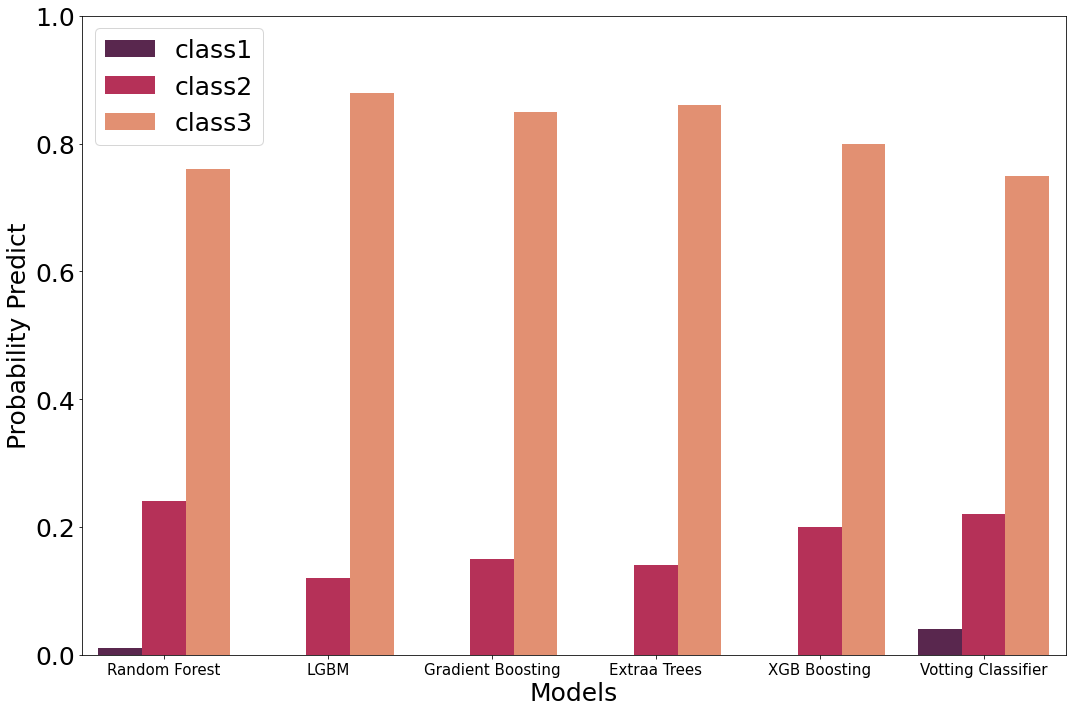

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

sns.color_palette("rocket", as_cmap=True)

sns.barplot(data=df_models, x='models', y='percent', hue='classe', palette='rocket')

plt.ylim([0, 1])
plt.legend(prop={'size': 25})
plt.ylabel('Probability Predict', size=25)
plt.xlabel('Models', size=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

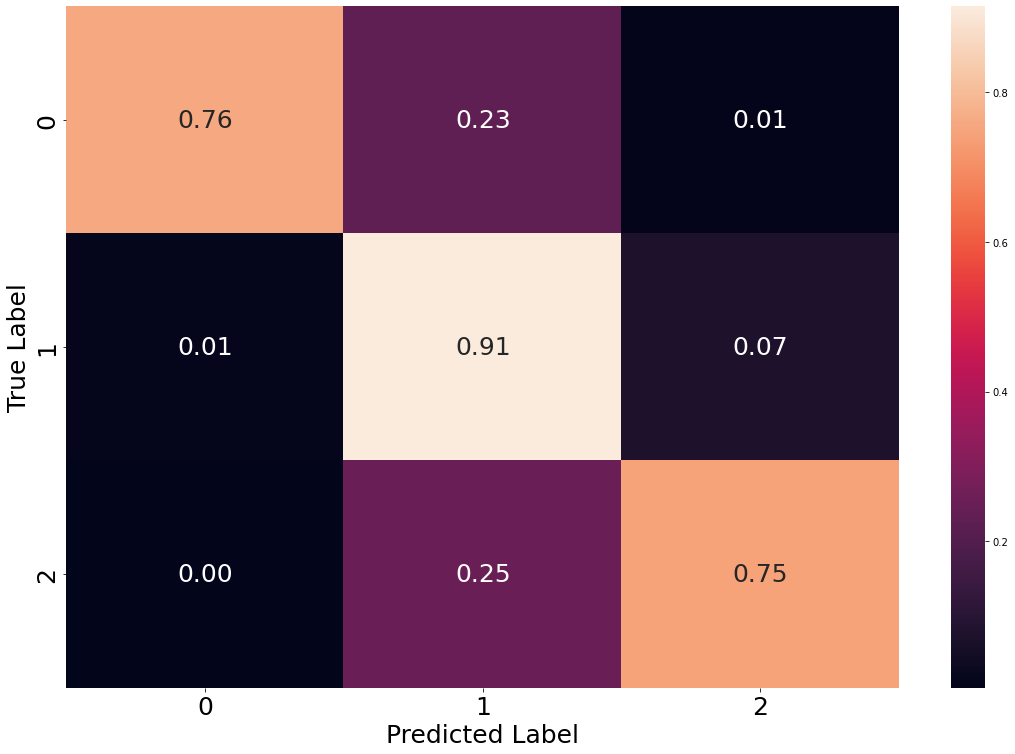

In [ ]:
cm = confusion_matrix(fy_tr, pred_votting, labels=voting_clf.classes_)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cmn, annot=True, fmt='.2f', annot_kws={'size': 25}, ax=ax)
fig.tight_layout()
plt.ylabel('True Label', size=25)
plt.xlabel('Predicted Label', size=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show(block=False)

# Submit

In [ ]:
pred_votting_base_test = voting_clf.predict(fx_te)

sub_csv = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/submission_format.csv")

sub_csv["damage_grade"] = pred_votting_base_test
sub_csv.to_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/output/submit/class_balanced_test_8.csv", index=False)

In [ ]:
sub_csv = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/submission_format.csv")

sub_csv["damage_grade"] = pred_votting_base_test
sub_csv.to_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/output/submit/ensemble_1.csv", index=False)

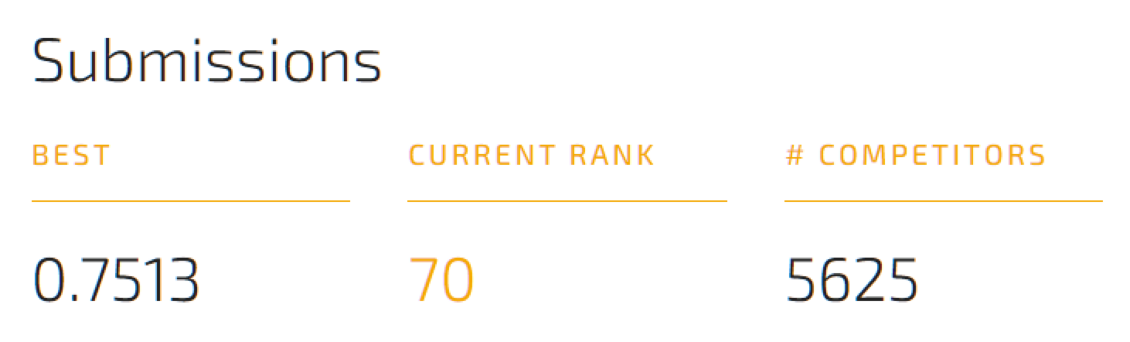

In [ ]:
img = cv2.imread("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/Results 2022-08-08.png")

plt.figure(figsize=(20, 16))
plt.imshow(img)
plt.axis('off')
plt.show()